In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mhskii","key":"9d67a7721b6e1c2dc98c81c3420c05bd"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!ls

100% 2.29G/2.29G [00:25<00:00, 78.1MB/s]
100% 2.29G/2.29G [00:25<00:00, 95.8MB/s]
chest-xray-pneumonia.zip  kaggle.json  sample_data


In [ ]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 17 not upgraded.


In [ ]:
!mkdir chest-xray-pneumonia

In [ ]:
!unzip /content/chest-xray-pneumonia.zip -d chest-xray-pneumonia

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/N

In [ ]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
IMG_SIZE = 224

TRAINING_DIR = "/content/chest-xray-pneumonia/chest_xray/train"
training_datagen = ImageDataGenerator(rescale = 1./255 ,
                                      shear_range=0.25,
                                      zoom_range=0.25)
train_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                       target_size=(IMG_SIZE,IMG_SIZE) ,class_mode='categorical',
                                                       batch_size=64,shuffle=True )


TEST_DIR = "/content/chest-xray-pneumonia/chest_xray/test"
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=(IMG_SIZE,IMG_SIZE), class_mode = None , batch_size = 64,
                                                  shuffle = False)


VAL_DIR = "/content/chest-xray-pneumonia/chest_xray/val"
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = val_datagen.flow_from_directory(TEST_DIR,target_size=(IMG_SIZE,IMG_SIZE),class_mode='categorical',
                                                       batch_size=64,shuffle= False)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


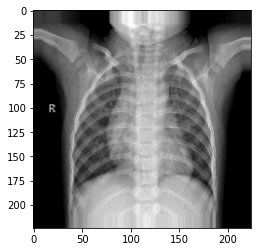

In [ ]:
x,y = train_generator.next()
for i in range(0,1):
    image = x[i]
    plt.imshow(image)
    plt.show()

In [ ]:
import tensorflow_hub as hub

URL = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4' 
feature_extractor = hub.KerasLayer(URL, input_shape=(224,224,3))
feature_extractor.trainable = False

In [ ]:
model = tf.keras.models.Sequential([    
    feature_extractor,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2,activation='softmax')
    
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_3 (Dense)              (None, 64)                131136    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 21,938,210
Trainable params: 135,426
Non-trainable params: 21,802,784
____________________________________

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs['accuracy']>=0.95):
      self.model.stop_training=True

callbacks=myCallback()
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')]
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=METRICS )

history = model.fit(train_generator , epochs=15 , callbacks=[callbacks], validation_data=val_generator)

Epoch 1/15
82/82 [==============================] - 627s 8s/step - loss: 0.5447 - accuracy: 0.7328 - precision: 0.7328 - recall: 0.7328 - val_loss: 0.5386 - val_accuracy: 0.7228 - val_precision: 0.7228 - val_recall: 0.7228
Epoch 2/15
82/82 [==============================] - 620s 8s/step - loss: 0.3328 - accuracy: 0.8622 - precision: 0.8622 - recall: 0.8622 - val_loss: 0.5109 - val_accuracy: 0.7564 - val_precision: 0.7564 - val_recall: 0.7564
Epoch 3/15
82/82 [==============================] - 623s 8s/step - loss: 0.2697 - accuracy: 0.8928 - precision: 0.8928 - recall: 0.8928 - val_loss: 0.4879 - val_accuracy: 0.7885 - val_precision: 0.7885 - val_recall: 0.7885
Epoch 4/15
82/82 [==============================] - 623s 8s/step - loss: 0.2422 - accuracy: 0.9003 - precision: 0.9003 - recall: 0.9003 - val_loss: 0.4381 - val_accuracy: 0.8093 - val_precision: 0.8093 - val_recall: 0.8093
Epoch 5/15
82/82 [==============================] - 623s 8s/step - loss: 0.2346 - accuracy: 0.9095 - precisi

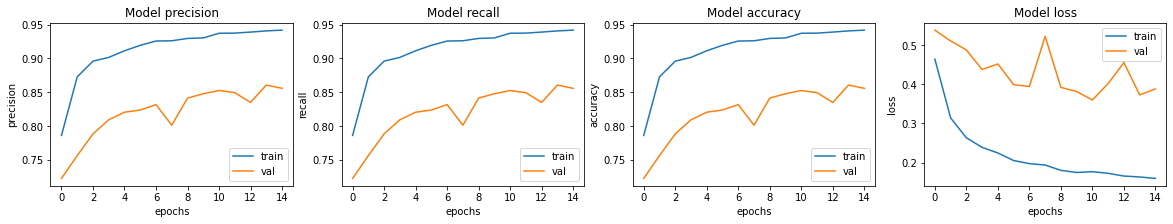

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
model.evaluate(val_generator)

10/10 [==============================] - 63s 6s/step - loss: 0.3884 - accuracy: 0.8558 - precision: 0.8558 - recall: 0.8558


[0.3883855640888214,
 0.8557692170143127,
 0.8557692170143127,
 0.8557692170143127]

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
model.save('/content/transferlearning')

INFO:tensorflow:Assets written to: /content/transferlearning/assets


INFO:tensorflow:Assets written to: /content/transferlearning/assets


In [ ]:
!zip -r /content/transferlearning.zip /content/transferlearning

  adding: content/transferlearning/ (stored 0%)
  adding: content/transferlearning/variables/ (stored 0%)
  adding: content/transferlearning/variables/variables.index (deflated 80%)
  adding: content/transferlearning/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/transferlearning/saved_model.pb (deflated 93%)
  adding: content/transferlearning/assets/ (stored 0%)
